In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
#Additional libraries for efficient index manipulation
from collections import deque
#SVD
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split as suprise_train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
#Keras
from keras.models import Model
from keras.layers import Input, Embedding, Reshape, Concatenate, Dense
from keras.optimizers import Adam
from keras.losses import MeanSquaredError, MeanAbsoluteError

# Data Preprocessing

In [2]:
# Read movie_titles dataset
df_titles = pd.read_csv('movie_titles.csv', 
                           encoding = 'ISO-8859-1', 
                           header = None,
                           usecols=[0,1,2],
                           names = ['Movie_ID', 'Year_of_Release', 'Movie_Title']).set_index('Movie_ID')

In [3]:
df_titles.head()

,Year_of_Release,Movie_Title
Movie_ID,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [4]:
df_titles.shape

(17770, 2)

There are 17770 different movies in this dataset

## Check Missing Value

In [5]:
df_titles.isnull().sum()

Year_of_Release    7
Movie_Title        0
dtype: int64

There are 7 missing release years in this dataset, I will try to input them manually by searching for the release year of each film.

In [6]:
df_titles[df_titles["Year_of_Release"].isnull()]

,Year_of_Release,Movie_Title
Movie_ID,,
4388,NaN,Ancient Civilizations: Rome and Pompeii
4794,NaN,Ancient Civilizations: Land of the Pharaohs
7241,NaN,Ancient Civilizations: Athens and Greece
10782,NaN,Roti Kapada Aur Makaan
15918,NaN,Hote Hote Pyaar Ho Gaya
16678,NaN,Jimmy Hollywood
17667,NaN,Eros Dance Dhamaka



- **Ancient Civilizations: Athens and Greece** -> 2001 (https://www.amazon.com/Ancient-Civilizations-Athens-Greece/dp/B00005MKKF)
- **Ancient Civilizations: Rome and Pompeii** -> 2001 (https://www.amazon.com/Ancient-Civilizations-Athens-Greece/dp/B00005MKKF)
- **Ancient Civilizations: Land of the Pharaohs** -> 2001 (https://www.amazon.com/Rome-Pompeii/dp/B081ZNS4J8/)
- **Eros Dance Dhamaka** -> 1998 (https://www.neverdiemedia.com/products/eros-dance-dhamaka)
- **Jimmy Hollywood** -> 1994 (https://www.imdb.com/title/tt0110197/)
- **Hote Hote Pyaar Ho Gaya** -> 1999 (https://www.imdb.com/title/tt0206020/)
- **Roti Kapada Aur Makaan** -> 1974 (https://www.imdb.com/title/tt0072100/)




In [7]:
# Update Year_of_Release manually using the index
df_titles.loc[4388, 'Year_of_Release'] = 2001  # Ancient Civilizations: Rome and Pompeii
df_titles.loc[4794, 'Year_of_Release'] = 2001  # Ancient Civilizations: Land of the Pharaohs
df_titles.loc[7241, 'Year_of_Release'] = 2001  # Ancient Civilizations: Athens and Greece
df_titles.loc[10782, 'Year_of_Release'] = 1974  # Roti Kapada Aur Makaan
df_titles.loc[15918, 'Year_of_Release'] = 1999  # Hote Hote Pyaar Ho Gaya
df_titles.loc[16678, 'Year_of_Release'] = 1994  # Jimmy Hollywood
df_titles.loc[17667, 'Year_of_Release'] = 1998  # Eros Dance Dhamaka

# Verify the updates
print(df_titles.loc[[4388, 4794, 7241, 10782, 15918, 16678, 17667]])


          Year_of_Release                                  Movie_Title
Movie_ID                                                              
4388               2001.0      Ancient Civilizations: Rome and Pompeii
4794               2001.0  Ancient Civilizations: Land of the Pharaohs
7241               2001.0     Ancient Civilizations: Athens and Greece
10782              1974.0                       Roti Kapada Aur Makaan
15918              1999.0                      Hote Hote Pyaar Ho Gaya
16678              1994.0                              Jimmy Hollywood
17667              1998.0                           Eros Dance Dhamaka


In [8]:
df_titles["Year_of_Release"].isnull().sum()

0

There are no missing values ​​in the data

## Check Data Types

In [9]:
df_titles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17770 entries, 1 to 17770
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year_of_Release  17770 non-null  float64
 1   Movie_Title      17770 non-null  object 
dtypes: float64(1), object(1)
memory usage: 932.5+ KB


For the release year, the data is better in int than float

In [10]:
df_titles["Year_of_Release"] = df_titles["Year_of_Release"].astype(int)

In [11]:
df_titles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17770 entries, 1 to 17770
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Year_of_Release  17770 non-null  int32 
 1   Movie_Title      17770 non-null  object
dtypes: int32(1), object(1)
memory usage: 863.1+ KB


In [12]:
# Load and combine all four combined_data datasets
'''
Input:
- file_path: Path to the dataset file. Each movie is identified by an ID followed by a colon on a new line, followed by user ratings.

Process:
1. Data Loading:
   - df_raw: Loads the dataset into a DataFrame with columns for 'User', 'Rating', and 'Date'. Entries with movie IDs end with a colon in the 'User' column.

2. Movie Marker Detection:
   - tmp_movies: Identifies rows where 'Rating' is NaN, indicating the start of a new movie's data.
   - movie_indices: Lists indices with corresponding movie IDs to mark each movie's data start.

3. Index Adjustment:
   - shifted_movie_indices: Adjusts indices to facilitate data slicing based on movies.

4. Data Slicing per Movie:
   - Iterates through movie indices to slice and create DataFrames for each movie with a designated 'Movie_ID'.

5. Data Aggregation:
   - Aggregates sliced DataFrames into a single comprehensive DataFrame.

6. Memory Management:
   - Clears temporary data structures to optimize memory usage.

Output:
- df: A merged DataFrame including a 'Movie_ID' column, ready for further analysis or processing.
'''

def process_data(file_path):
    df_raw = pd.read_csv(file_path, header=None, names=['User', 'Rating', 'Date'], usecols=[0, 1, 2])
    
    # Detect rows indicating new movies by checking for NaN in 'Rating'
    tmp_movies = df_raw[df_raw['Rating'].isna()]['User'].reset_index()
    movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]
    
    # Adjust indices for effective slicing
    shifted_movie_indices = deque(movie_indices)
    shifted_movie_indices.rotate(-1)
    
    # Collect DataFrames for each movie
    user_data = []
    
    # Extract data for each movie using the prepared indices
    for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):
        
        # Select data for the current movie
        if df_id_1 < df_id_2:
            tmp_df = df_raw.loc[df_id_1+1:df_id_2-1].copy()
        else:  # Handle the last movie extending to the end of the dataset
            tmp_df = df_raw.loc[df_id_1+1:].copy()
        
        # Assign movie ID to the sliced data
        tmp_df['Movie_ID'] = movie_id
        
        # Store the movie DataFrame
        user_data.append(tmp_df)
    
    # Concatenate all individual movie DataFrames
    df = pd.concat(user_data)
    
    # Clean up to release memory
    del user_data, df_raw, tmp_movies, tmp_df, shifted_movie_indices, movie_indices
    
    return df

# Process each dataset file and merge them
df1 = process_data('combined_data_1.txt')
df2 = process_data('combined_data_2.txt')
df3 = process_data('combined_data_3.txt')
df4 = process_data('combined_data_4.txt')

# Combine the processed DataFrames into one final DataFrame
final_df = pd.concat([df1, df2, df3, df4])
print('Final Data Shape:', final_df.shape)
final_df.sample(5)


Final Data Shape: (100480507, 4)


,User,Rating,Date,Movie_ID
14255421,1535968,4.0,2005-10-16,11929
6566343,1922492,5.0,2005-01-09,1295
5453061,2165171,3.0,2005-02-14,1102
14008269,917008,4.0,2004-07-09,11886
23229584,88959,4.0,2005-08-30,8524


## Check Missing Value

In [13]:
final_df.isnull().sum()

User        0
Rating      0
Date        0
Movie_ID    0
dtype: int64

There are no missing values

In [14]:
df = final_df

## Check Data Types

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100480507 entries, 1 to 26851925
Data columns (total 4 columns):
 #   Column    Dtype  
---  ------    -----  
 0   User      object 
 1   Rating    float64
 2   Date      object 
 3   Movie_ID  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.7+ GB


All variables are in the correct format

## Merge The Two Dataset by Movie_ID as index

In [16]:
# Merge df with df_titles where df_titles is indexed by Movie_ID
df = pd.merge(df, df_titles, left_on='Movie_ID', right_index=True)

# Check the merged DataFrame
df.head()

,User,Rating,Date,Movie_ID,Year_of_Release,Movie_Title
1,1488844,3.0,2005-09-06,1,2003,Dinosaur Planet
2,822109,5.0,2005-05-13,1,2003,Dinosaur Planet
3,885013,4.0,2005-10-19,1,2003,Dinosaur Planet
4,30878,4.0,2005-12-26,1,2003,Dinosaur Planet
5,823519,3.0,2004-05-03,1,2003,Dinosaur Planet


# EDA

In [17]:
# Let's take a look at the highest rated movie titles
ratings = pd.DataFrame(df.groupby("Movie_Title")["Rating"].mean())
ratings_sorted = ratings.sort_values("Rating", ascending=False)  # Sort ratings in descending order
ratings_sorted.head()

,Rating
Movie_Title,
Lord of the Rings: The Return of the King: Extended Edition,4.723270
The Lord of the Rings: The Fellowship of the Ring: Extended Edition,4.716611
Lord of the Rings: The Two Towers: Extended Edition,4.702611
Lost: Season 1,4.670989
Battlestar Galactica: Season 1,4.638809


We can see some of the highest rated films, but often this is biased because it is possible that films that only a few users have rated are also included in the calculation.

In [18]:
# Let's take a look at the most rated movies among users
user = pd.DataFrame(df.groupby("User")["Rating"].count())
user_sorted = user.sort_values("Rating", ascending=False)  # Sort by rating count in descending order
user_sorted.head()

,Rating
User,
305344,17653
387418,17436
2439493,16565
1664010,15813
2118461,14831


We can see which movies are the most rated.

# Distribution of Ratings (Movies & Users) 

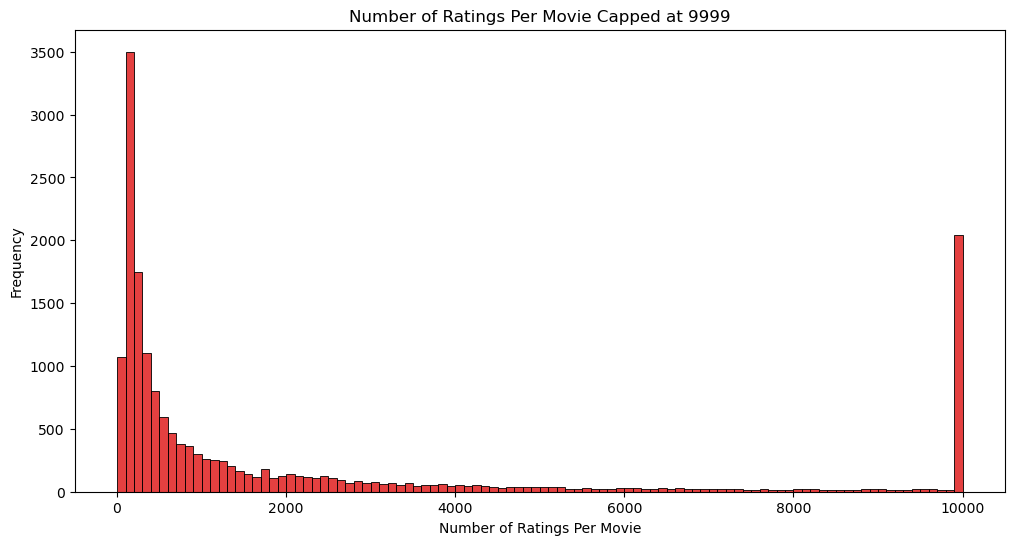

Text(0, 0.5, 'Frequency')

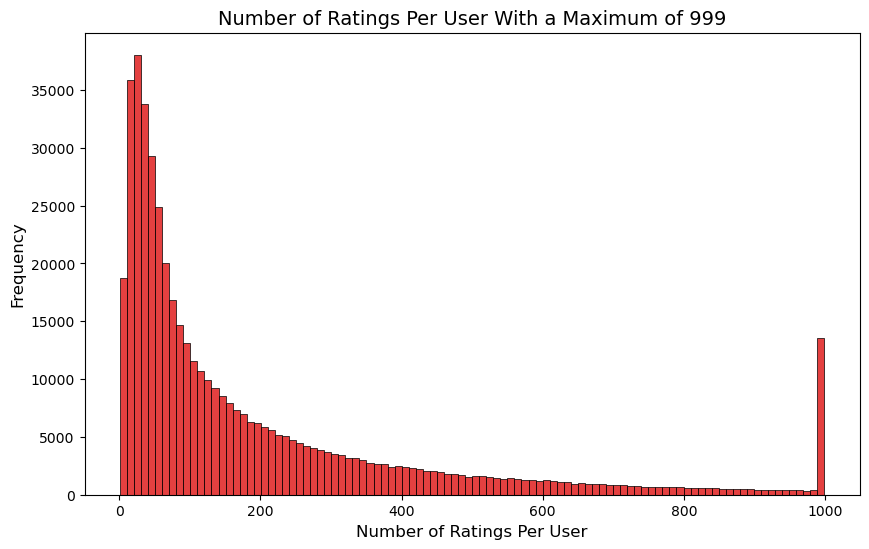

In [19]:
# Ratings Per Movie
plt.figure(figsize=(12, 6))
# Group the data by movie titles and count ratings, limiting the maximum count to 9999 for any movie
movie_data = df.groupby('Movie_Title')['Rating'].count().clip(upper=9999)

bins = range(0, 10000, 100)

# Create a histogram with specific bin settings and a red color
sns.histplot(movie_data, bins=100, color='#db0000')
# Title and labels for the histogram showing rating distribution with a maximum cap
plt.title('Number of Ratings Per Movie Capped at 9999')
plt.xlabel('Number of Ratings Per Movie')
plt.ylabel('Frequency')
plt.show()

# Ratings Per User
# Aggregate ratings per user, with a maximum count cap at 999
data = df.groupby('User')['Rating'].count().clip(upper=999)

# Plot using seaborn, without a kernel density estimate
plt.figure(figsize=(10, 6))
sns.histplot(data.values, bins=100, color='#db0000', kde=False)

# Add a title and axis labels using a larger font size
plt.title('Number of Ratings Per User With a Maximum of 999', fontsize=14)
plt.xlabel('Number of Ratings Per User', fontsize=12)
plt.ylabel('Frequency', fontsize=12)


The histograms indicate that most movies and users have a low number of ratings, with a few exceptions that have significantly higher ratings. Given the large dataset size of **100 million ratings**, I decided to focus my recommendation system models on a subset of the data—specifically, users who have rated at least **1000 movies** and movies that have received at least **10,000 ratings**. This filtering will help manage the vast data volume by reducing noise and ensuring the model focuses on more reliable, frequently reviewed content, potentially improving the system's predictive accuracy and relevance.


## Joint Distribution of Ratings & Number of Ratings

Text(0.5, 1.05, 'Joint Distribution of Ratings and Number of Ratings')

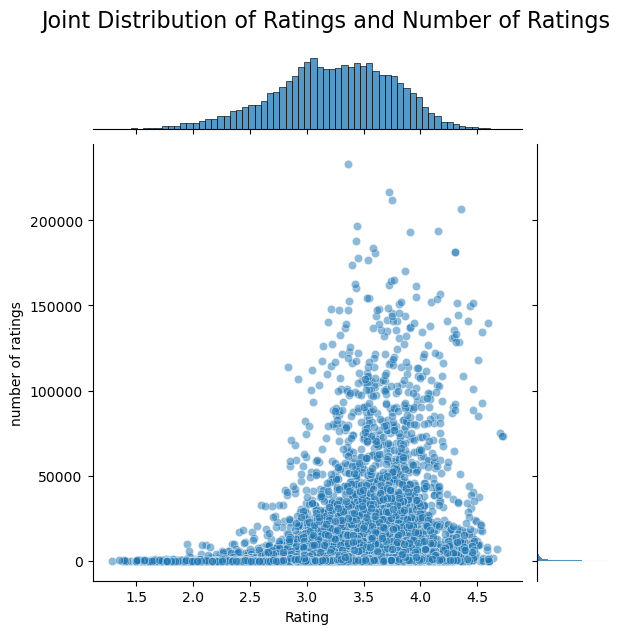

In [20]:
# Create a new column 'number of ratings' in the 'ratings' DataFrame to track the total ratings each movie receives.
ratings["number of ratings"] = pd.DataFrame(df.groupby("Movie_Title")["Rating"].count())

# Check the first entries in the updated DataFrame to confirm the addition of the new column.
ratings.head()

# Generate a joint plot using seaborn to illustrate the correlation between average ratings of movies and the number of times they've been rated.
joint_plot = sns.jointplot(x='Rating', y="number of ratings", data=ratings, alpha=0.5)
joint_plot.fig.suptitle('Joint Distribution of Ratings and Number of Ratings', fontsize=16, y=1.05)

The joint distribution plot reveals that the majority of ratings fall between **3 and 4**, suggesting that movies are typically well-received. There's a clear pattern showing that films with **higher ratings** often have **more reviews**, indicating that popular movies tend to receive higher ratings. Additionally, the trend leans towards **higher ratings**, showing that users generally prefer to give positive ratings to movies.


## Movie Ratings Distribution

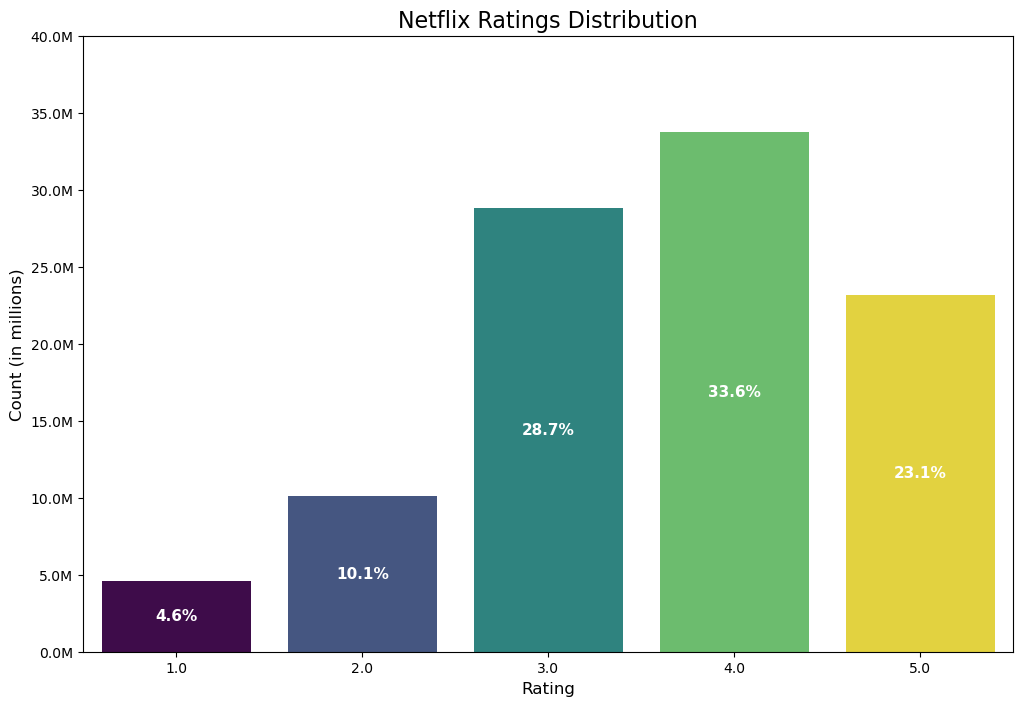

In [21]:
# Extracting the 'Rating' data from the dataframe
data = df['Rating'].value_counts().sort_index()

# Creating a bar plot with a specific color palette
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=data.index, y=data.values, hue=data.index, palette="viridis", dodge=False)
ax.legend([],[], frameon=False)

# Enhancing the plot with descriptive titles and labels
total_count = df.shape[0]
ax.set_title('Netflix Ratings Distribution', fontsize=16)
ax.set_xlabel('Rating', fontsize=12)
ax.set_ylabel('Count (in millions)', fontsize=12)

# Setting y-tick labels with a million scale formatting
ytick_values = ax.get_yticks()
ax.set_yticks(ytick_values)
ax.set_yticklabels(['{:.1f}M'.format(y / 1e6) for y in ytick_values])

# Adding percentage labels within each bar for better visualization
for i, value in enumerate(data.values):
    percentage = value / total_count * 100
    # Position text in the middle of the bar for clarity
    ax.text(i, value / 2, '{:.1f}%'.format(percentage),
            ha='center', va='center', color='white', fontsize=11, fontweight='bold')

From the distribution above, it can be seen that **most of the ratings given by users are 4 followed by 3** which represents about **62.3%** of the entire distribution. From the distribution, it is also clear that movies on Netflix are **rarely below 3**.

## Time series number of movies per year

Text(0, 0.5, 'Number of Movies')

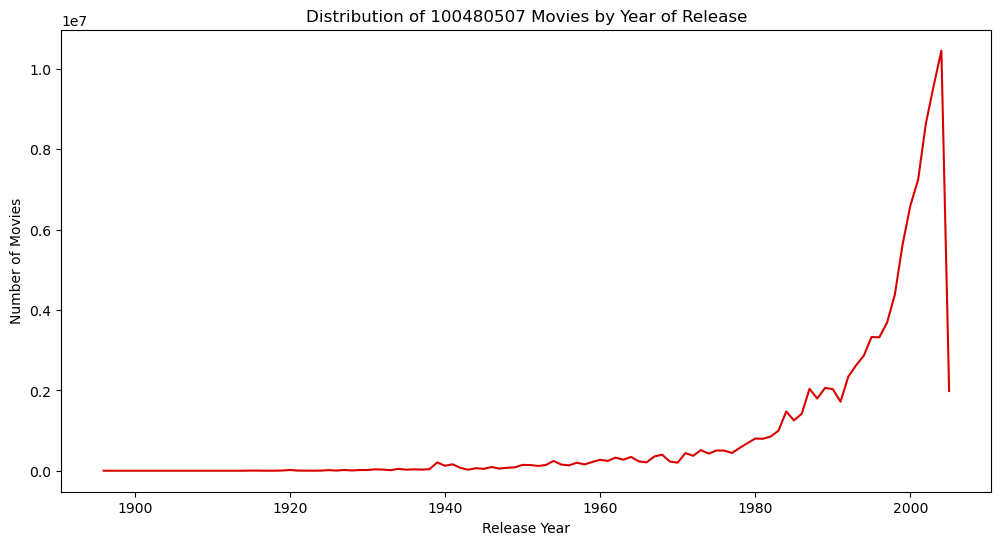

In [22]:
# Extract the data
data_ = df['Year_of_Release'].value_counts().sort_index()

# Creating a line plot using Seaborn to display the number of movies released per year
plt.figure(figsize=(12, 6))
sns.lineplot(x=data_.index, y=data_.values, color='#db0000')  # Corrected variable name here

# Setting the plot's title and labels
plt.title('Distribution of {} Movies by Year of Release'.format(df.shape[0]))
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')

As the **20th century progressed**, the **number of film releases** increased steadily. The recent decline observed towards the end of the timeline is likely due to **incomplete data entries** for the last year.

# Model Preparation

## Feature Selection

In [23]:
df = df[['User', 'Movie_ID', 'Rating']]

## Filtering Data to Focus on High-Volume Movies and Users

In [24]:
# Set minimum ratings thresholds
min_movie_ratings = 10000  # Movies must have more than 10,000 ratings
min_user_ratings = 1000    # Users must have more than 1,000 ratings

# Calculate counts for movies and users
movie_counts = df['Movie_ID'].value_counts()
user_counts = df['User'].value_counts()

# Apply combined filtering
df_filtered = df[
    df['Movie_ID'].isin(movie_counts[movie_counts > min_movie_ratings].index) & 
    df['User'].isin(user_counts[user_counts > min_user_ratings].index)
]

# Print shapes of the original and filtered DataFrames
print('Shape User-Ratings unfiltered:\t{}'.format(df.shape))
print('Shape User-Ratings filtered:\t{}'.format(df_filtered.shape))

Shape User-Ratings unfiltered:	(100480507, 3)
Shape User-Ratings filtered:	(12137651, 3)


In [25]:
df = df_filtered

In [26]:
df.sample()

,User,Movie_ID,Rating
2974031,1904865,13883,4.0


As discussed, the dataset will be subsetted to include only movies with a minimum of **10,000 ratings** and users with at least **1,000 ratings**. This strategy not only concentrates on the more dependable data but also cuts down on processing time and memory use, enhancing the efficiency of further analysis

# Models

## Collaborative Filtering with SVD

In [27]:
# Setup the reader with the rating scale
reader = Reader(rating_scale=(1, 5))

# Load the data from the DataFrame
data = Dataset.load_from_df(df, reader)

# Splitting the dataset into training and testing sets (SVD)
trainset, testset = suprise_train_test_split(data, test_size=0.2, random_state=42)

In [28]:
# Initialize the SVD algorithm
algo = SVD()

# Train the algorithm on the training set
algo.fit(trainset)

# Generate predictions on the test set
predictions = algo.test(testset)

## Evaluation Metrics

In [29]:
accuracy.mse(predictions)
accuracy.rmse(predictions)
accuracy.mae(predictions)

MSE: 0.5915
RMSE: 0.7691
MAE:  0.5962


0.5962122026762651

### Evaluation Metrics Overview:
- **MSE (Mean Squared Error): 0.5915** - This value suggests a **moderate level of inaccuracies** in the predictions. It's an indication that while there are errors, they're within a reasonable range considering the rating scale from 1 to 5.
- **RMSE (Root Mean Squared Error): 0.7691** - The model's predictions deviate from the actual ratings by about **0.7691 points**. This provides a realistic measure of error magnitude.
- **MAE (Mean Absolute Error): 0.5962** -  An MAE around **0.6** indicates that the model is fairly precise, with most predictions not straying too far from the truth on average.

### Conclusion:
The SVD model performs competently in estimating movie ratings, with the error metrics indicating **satisfactory but not perfect accuracy**. The proximity of **RMSE to MAE** suggests that the model does not suffer from significant skew from large outliers in its predictions. To enhance the model's performance, one could explore **refining the tuning of its parameters**, **adding richer contextual information**, or **upgrading to more complex algorithms such as SVD++**.


## Hypertuning SVD parameter

In [30]:
'''
# Define the parameter grid
param_grid = {
    'n_factors': [50, 100, 150],   # Number of latent factors
    'n_epochs': [20, 30],          # Number of epochs for stochastic gradient descent (SGD)
    'lr_all': [0.005, 0.01],       # Learning rate for all parameters
    'reg_all': [0.02, 0.1]         # Regularization term for all parameters
}

# Set up GridSearchCV with the SVD algorithm, the parameter grid, and cross-validation (cv=3)
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fit GridSearchCV
gs.fit(data)

# Print the best RMSE score and the corresponding parameters
print(f"Best RMSE score: {gs.best_score['rmse']}")
print(f"Best parameters for RMSE: {gs.best_params['rmse']}")

# Print the best MAE score and the corresponding parameters
print(f"Best MAE score: {gs.best_score['mae']}")
print(f"Best parameters for MAE: {gs.best_params['mae']}")
'''

'\n# Define the parameter grid\nparam_grid = {\n    \'n_factors\': [50, 100, 150],   # Number of latent factors\n    \'n_epochs\': [20, 30],          # Number of epochs for stochastic gradient descent (SGD)\n    \'lr_all\': [0.005, 0.01],       # Learning rate for all parameters\n    \'reg_all\': [0.02, 0.1]         # Regularization term for all parameters\n}\n\n# Set up GridSearchCV with the SVD algorithm, the parameter grid, and cross-validation (cv=3)\ngs = GridSearchCV(SVD, param_grid, measures=[\'rmse\', \'mae\'], cv=3, n_jobs=-1)\n\n# Fit GridSearchCV\ngs.fit(data)\n\n# Print the best RMSE score and the corresponding parameters\nprint(f"Best RMSE score: {gs.best_score[\'rmse\']}")\nprint(f"Best parameters for RMSE: {gs.best_params[\'rmse\']}")\n\n# Print the best MAE score and the corresponding parameters\nprint(f"Best MAE score: {gs.best_score[\'mae\']}")\nprint(f"Best parameters for MAE: {gs.best_params[\'mae\']}")\n'

I have tried it, unfortunately even though it has been **4 days** it is still not finished. Due to **time constraints**, I will try it another time

## COllaborative Foiltering with ANN (Deep Learning)

In [31]:
df_2 = df

# Initialize the encoders
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

# Apply encoding
df_2['User'] = user_encoder.fit_transform(df_2['User']).astype(np.int32)
df_2['Movie_ID'] = movie_encoder.fit_transform(df_2['Movie_ID']).astype(np.int32)

# Splitting the dataset
train, test = train_test_split(df_2, test_size=0.2, random_state=42)

# Extract data for the model
train_user_data = train['User'].values
train_movie_data = train['Movie_ID'].values
train_ratings = train['Rating'].values.astype('float32')

test_user_data = test['User'].values
test_movie_data = test['Movie_ID'].values
test_ratings = test['Rating'].values.astype('float32')

In [32]:
# Model parameters
users = df_2['User'].nunique()
movies = df_2['Movie_ID'].nunique()
user_embedding_size = 20
movie_embedding_size = 10

# Input layers
user_id_input = Input(shape=(1,), dtype='int32', name='user_input')
movie_id_input = Input(shape=(1,), dtype='int32', name='movie_input')

# Embedding layers
user_embedding = Embedding(input_dim=users, output_dim=user_embedding_size, name='user_embedding')(user_id_input)
movie_embedding = Embedding(input_dim=movies, output_dim=movie_embedding_size, name='movie_embedding')(movie_id_input)

# Reshape the embeddings
user_vector = Reshape((user_embedding_size,))(user_embedding)
movie_vector = Reshape((movie_embedding_size,))(movie_embedding)

# Concatenate the embeddings
concat = Concatenate()([user_vector, movie_vector])

# Dense layers for learning interactions
dense = Dense(128, activation='relu')(concat)
output = Dense(1)(dense)

# Create and compile the model
model = Model(inputs=[user_id_input, movie_id_input], outputs=output)
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ movie_input (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_embedding (Embedding)    │ (None, 1, 20)             │         262,000 │ user_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ movie_embedding (Embedding)   │ (None, 1, 10)             │          20,420 │ movie_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 20)                │               0 │ user_embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_1 (Reshape)           │ (None, 10)                │               0 │ movie_embedding[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 30)                │               0 │ reshape[0][0],             │
│                               │                           │                 │ reshape_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │           3,968 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │             129 │ dense[0][0]                │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 286,517 (1.09 MB)

 Trainable params: 286,517 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

### Neural Network Model Architecture Summary

- **Input Layers:**
  - `user_input`: Accepts individual user IDs.
  - `movie_input`: Accepts individual movie IDs.

- **Embedding Layers:**
  - `user_embedding`: Transforms user IDs into a 20-dimensional vector space (262,000 parameters).
  - `movie_embedding`: Transforms movie IDs into a 10-dimensional vector space (20,420 parameters).

- **Reshaping and Concatenation:**
  - Reshapes embedding outputs and concatenates them into a 30-dimensional vector.

- **Dense Layers:**
  - A dense layer with 128 neurons followed by an output layer with 1 neuron for predicting ratings.

- **Model Parameters:**
  - Total parameters: 286,517, all of which are trainable, suggesting a moderately complex model capable of capturing detailed interactions.

### Key Observations:

- **Embedding Utility:** The model effectively utilizes embeddings to capture nuanced user behaviors and movie characteristics, facilitating personalized recommendations.
  
- **Model Complexity:** The architecture balances complexity with manageability, suitable for capturing complex patterns without excessive risk of overfitting.

- **Output Strategy:** A single output neuron indicates the model's focus on predicting a continuous variable, typical for rating predictions.


In [33]:
# Train the model
model.fit([train_user_data, train_movie_data], train_ratings, epochs=5, batch_size=32, validation_split=0.1)

# Predict the test set
y_pred = model.predict([test_user_data, test_movie_data]).flatten()

Epoch 1/5
273098/273098 ━━━━━━━━━━━━━━━━━━━━ 327s 1ms/step - loss: 0.8278 - val_loss: 0.7142
Epoch 2/5
273098/273098 ━━━━━━━━━━━━━━━━━━━━ 325s 1ms/step - loss: 0.7008 - val_loss: 0.6894
Epoch 3/5
273098/273098 ━━━━━━━━━━━━━━━━━━━━ 332s 1ms/step - loss: 0.6757 - val_loss: 0.6718
Epoch 4/5
273098/273098 ━━━━━━━━━━━━━━━━━━━━ 329s 1ms/step - loss: 0.6584 - val_loss: 0.6638
Epoch 5/5
273098/273098 ━━━━━━━━━━━━━━━━━━━━ 329s 1ms/step - loss: 0.6461 - val_loss: 0.6568
75861/75861 ━━━━━━━━━━━━━━━━━━━━ 49s 641us/step


- **Consistent Improvement**: The model shows continuous improvement as both training and validation losses decrease with each epoch. This trend suggests that the model is learning effectively and is able to generalize well from the training dataset.

- **Validation Loss**: The similarity between the training and validation losses indicates that the model maintains a balanced learning approach, with no significant overfitting to the training data.

## Evaluation Metric

In [34]:
# Calculate RMSE and MAE
mse = MeanSquaredError()
mse_result = mse(test_ratings, y_pred).numpy()
mae = MeanAbsoluteError()
rmse_result = np.sqrt(mse(test_ratings, y_pred).numpy())
mae_result = mae(test_ratings, y_pred).numpy()

print(f'MSE: {mse_result:.4f}')
print(f'RMSE: {rmse_result:.4f}')
print(f'MAE: {mae_result:.4f}')


MSE: 0.6564
RMSE: 0.8102
MAE: 0.6268


### Evaluation Metrics Overview:
- **MSE (Mean Squared Error): 0.6564** - This metric shows a moderate level of prediction inaccuracies. It quantifies the average of the squared differences between the predicted and actual ratings, suggesting that while there are errors, they fall within an acceptable range on the typical 1 to 5 rating scale.
- **RMSE (Root Mean Squared Error): 0.8102** - This value indicates the standard deviation of the prediction errors, measuring how much the model's predictions deviate from the actual ratings. An RMSE of 0.8102 points out that, on average, the predictions are off by less than one rating point, providing a practical measure of error magnitude.
- **MAE (Mean Absolute Error): 0.6268** - With an MAE of about 0.6268, this metric demonstrates that the model predicts ratings with fair precision. The predictions typically vary from the true values by slightly over half a point on average, highlighting the model's reasonable accuracy.

### Conclusion:
The ANN model exhibits **solid performance** in predicting movie ratings, although the error metrics reveal there is **potential for improvement**. The **proximity of RMSE to MAE** implies a **consistent error range** across predictions without extreme outliers affecting the overall accuracy significantly. To **optimize the model's effectiveness**, strategies might include more **detailed parameter tuning**, **integrating richer contextual or content-based features**, or **exploring more advanced neural network architectures**.


## SVD vs ANN

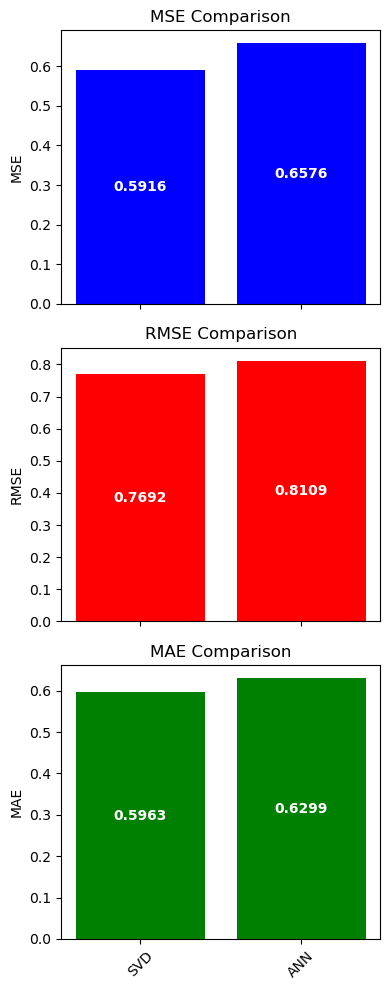

In [35]:
# Algorithms and metrics
algorithms = ['SVD', 'ANN']
mse = [0.5916, 0.6576]
rmse = [0.7692, 0.8109]
mae = [0.5963, 0.6299]

# Creating subplots
fig, ax = plt.subplots(3, 1, figsize=(4, 10), sharex=True)

# Plotting and adding text labels for MSE
bars = ax[0].bar(algorithms, mse, color='blue')
ax[0].set_title('MSE Comparison')
ax[0].set_ylabel('MSE')
for bar in bars:
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width()/2, yval / 2, f'{yval:.4f}', ha='center', va='center', color='white', fontweight='bold')

# Plotting and adding text labels for RMSE
bars = ax[1].bar(algorithms, rmse, color='red')
ax[1].set_title('RMSE Comparison')
ax[1].set_ylabel('RMSE')
for bar in bars:
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, yval / 2, f'{yval:.4f}', ha='center', va='center', color='white', fontweight='bold')

# Plotting and adding text labels for MAE
bars = ax[2].bar(algorithms, mae, color='green')
ax[2].set_title('MAE Comparison')
ax[2].set_ylabel('MAE')
for bar in bars:
    yval = bar.get_height()
    ax[2].text(bar.get_x() + bar.get_width()/2, yval / 2, f'{yval:.4f}', ha='center', va='center', color='white', fontweight='bold')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()

### Model Performance Summary:

The charts compare two distinct models, SVD and ANN, across various standard metrics used to evaluate prediction accuracy.

- **MSE Evaluation**: SVD demonstrates a more efficient prediction accuracy with a lower MSE of 0.5916, as opposed to ANN's MSE of 0.6576. This suggests that SVD has a tighter grip on minimizing prediction errors.
- **RMSE Insights**: In the realm of RMSE, SVD continues to lead with a score of 0.7692 compared to ANN's 0.8109, indicating smaller deviations in SVD's predictions relative to the true values.
- **MAE Observations**: Consistently, SVD records a lower MAE of 0.5963 against ANN's 0.6299, highlighting its superior ability to predict ratings with minimal error.

### Final Thoughts:

Overall, **SVD** appears to be more adept at handling the dataset, showcasing **higher prediction precision** across all metrics compared to the **ANN**. This superiority suggests a potentially more reliable model for applications demanding **high accuracy** in recommendations.


## Top 10 Recommended Movies

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Text(0, 0.5, 'Movie Title')

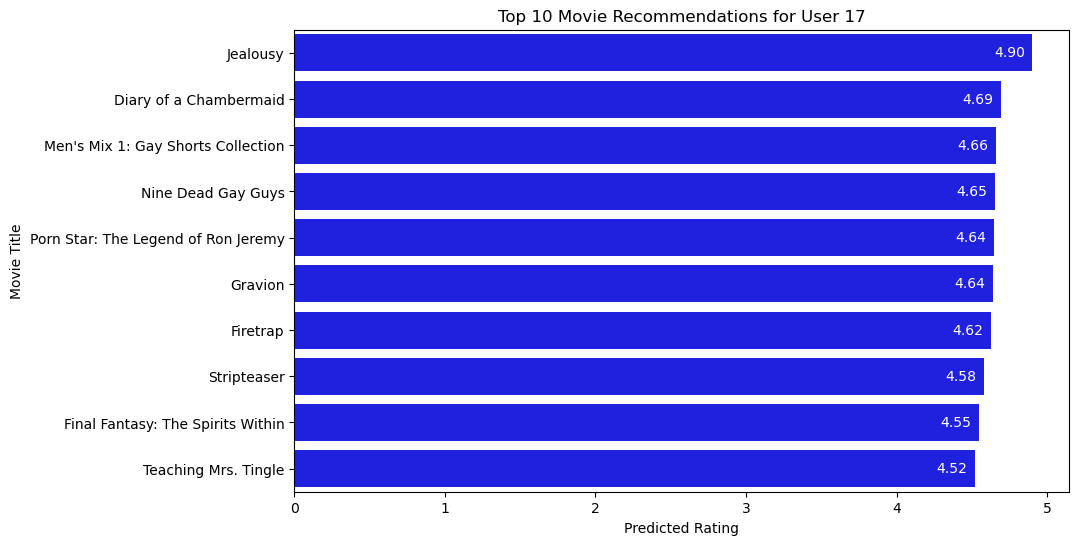

In [49]:
# Setting the user ID for whom the recommendations will be personalized
user_id = 17

# Retrieving the complete set of movie IDs available in the dataset
all_movies = set(df_2['Movie_ID'].unique())

# Identifying the subset of movies this particular user has already reviewed
rated_movies_by_user = set(df_2[df_2['User'] == user_id]['Movie_ID'])

# Isolating the set of movies that haven't yet been rated by the user
unrated_movies = list(all_movies - rated_movies_by_user)

# Configuring the model inputs with the user ID repeated for each movie
user_input_array = np.array([user_id] * len(unrated_movies))
movie_input_array = np.array(unrated_movies)

# Employing the neural network to estimate ratings for the unrated movies
estimated_ratings = model.predict([user_input_array, movie_input_array]).flatten()

# Pairing each movie ID with its corresponding predicted rating
movie_ratings_pair = list(zip(unrated_movies, estimated_ratings))

# Ordering the predictions to highlight the top 10 recommendations
top_ten_recommendations = sorted(movie_ratings_pair, key=lambda x: x[1], reverse=True)[:10]

# Compiling the top recommendations into a DataFrame for better visualization
visualization_df = pd.DataFrame(top_ten_recommendations, columns=['Movie_ID', 'Predicted_Rating'])

# Enriching the DataFrame with movie titles by merging with the titles dataset
visualization_df = visualization_df.merge(df_titles, on='Movie_ID')

# Visualizing the top 10 movie recommendations along with their predicted ratings
plt.figure(figsize=(10, 6))
recommendation_plot = sns.barplot(x='Predicted_Rating', y='Movie_Title', data=visualization_df, color='b', orient='h')

# Enhancing the visualization with annotations for each recommendation
for bar in recommendation_plot.patches:
    width = bar.get_width()  # The width of the bar represents the predicted rating
    plt.text(width - 0.05,  # Adjusting text placement to slightly inside the end of the bar
             bar.get_y() + bar.get_height() / 2,  # Centering text vertically within the bar
             '{:1.2f}'.format(width),  # Formatting the text to display the rating to two decimal places
             ha='right', va='center', color="white")  # Aligning the text right and vertically centered

plt.title(f'Top 10 Movie Recommendations for User {user_id}')
plt.xlabel('Predicted Rating')
plt.ylabel('Movie Title')

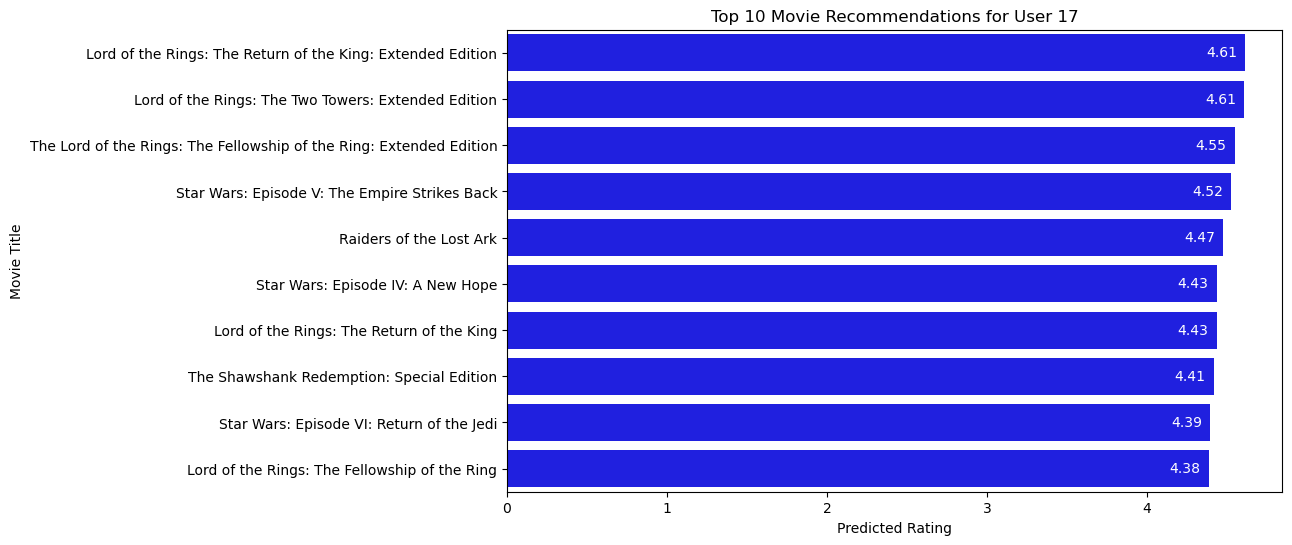

In [50]:
# Generate and visualize top 10 movie recommendations using a trained algorithm
'''
Input:
- user_id: The ID of the user for whom recommendations are to be generated.
- all_movie_ids: A unique set of movie IDs available in the dataset to consider for recommendations.
- df_titles: A DataFrame containing 'Movie_ID' and 'Movie_Title' for title lookup.

Process:
1. Recommendation Generation:
   - Iterate through each movie ID and use a predictive algorithm to estimate how well the user might rate each movie.
   - Store each movie ID along with its predicted rating.

2. Sorting and Filtering:
   - Sort the list of predicted ratings in descending order to prioritize movies with higher expected enjoyment.
   - Filter the list to retain only the top 10 recommendations based on the predicted ratings.

3. Data Preparation for Visualization:
   - Create a DataFrame from the top 10 recommendations that includes 'Movie_ID' and 'Predicted_Rating'.
   - Merge this DataFrame with another containing the movie titles to map each ID to its corresponding title.

4. Visualization:
   - Use a horizontal bar plot to display the predicted ratings alongside the movie titles.
   - Enhance visualization with text annotations on each bar to display the numeric rating values.

5. Memory Management:
   - Clean temporary data structures if necessary to optimize memory usage.

Output:
- Plot: A bar plot displaying the top 10 movie recommendations for the user, including the movie titles and their predicted ratings.
'''

def get_top_movie_recommendations(user_id, all_movie_ids, df_titles):
    recommendations = []
    for movie_id in all_movie_ids:
        prediction = algo.predict(user_id, movie_id)
        recommendations.append((movie_id, prediction.est))
    
    # Sort predictions and select the top 10
    recommendations.sort(key=lambda x: x[1], reverse=True)
    top_recommendations = recommendations[:10]

    # Prepare DataFrame for visualization
    recommendations_df = pd.DataFrame(top_recommendations, columns=['Movie_ID', 'Predicted_Rating'])
    recommendations_df = recommendations_df.merge(df_titles, on='Movie_ID')

    # Visualization
    plt.figure(figsize=(10, 6))
    recommendation_chart = sns.barplot(x='Predicted_Rating', y='Movie_Title', data=recommendations_df, color='b', orient='h')
    for bar in recommendation_chart.patches:
        width = bar.get_width()
        plt.text(width - 0.05, bar.get_y() + bar.get_height() / 2, '{:1.2f}'.format(width), ha='right', va='center', color="white")
    plt.title(f'Top 10 Movie Recommendations for User {user_id}')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Movie Title')
    plt.show()

# Example usage
user_id = 17
all_movie_ids = df_titles.index.unique()
get_top_movie_recommendations(user_id, all_movie_ids, df_titles)


### Overview
- **ANN Recommendations**: Features a broad selection of movies, including niche and less-known titles, with predicted ratings reaching up to 4.90.
- **SVD Recommendations**: Focuses on globally recognized and critically celebrated franchises, with top ratings around 4.61.

### Conclusion
- **Personalization**: The ANN model excels in delivering personalized movie suggestions that may appeal to specific, individual tastes.
- **Mainstream Appeal**: The SVD model caters effectively to general preferences, highlighting films with widespread acclaim and popularity.

In [53]:
!jupyter nbconvert --to html Final_Project.ipynb --output Final_Project.html


[NbConvertApp] Converting notebook Final_Project.ipynb to html
[NbConvertApp] Writing 942039 bytes to Final_Project.html
